In [27]:
import numpy as np
from matplotlib import pyplot as plt

import os
import pickle
from time import time
from sklearn.decomposition import PCA

import george
from george import kernels
from scipy.optimize import minimize

%matplotlib inline

In [28]:
param_names = ["Tstar","logL_star","logM_disk","logR_disk","h_0","logR_in",\
          "gamma","beta","logM_env","logR_env","f_cav","ksi","loga_max","p","incl"]
    
ranges = [[3000.,5000.], [-1,3.],[-8.,-2.], [0.,3.],[0.01,0.5],[-1.,2.5],[0.0,2.0],\
        [0.5,2.0],[-8.,-2.],[2.5,4.], [0.,1.], [0.5,1.5],[0.,5.],[2.5,4.5],[0.,90.]]
steps=[]
for i in range(len(ranges)):
    steps.append(np.linspace(ranges[i][0],ranges[i][1],11))

sl=[]
for i in range(11):
    x=[steps[0][i]]
    for j in range(len(ranges)-1):
        x.append(steps[j+1][5])
    sl.append(x)
    
dictionary=np.load("../grid_metadata/dictionary.npy")
    
# training set - read in filenames and logspace flux values
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))[:,100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))[:,100:500]    
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)[100:500]
    
# fix -infs: powerlaw cutoff
for i in range(len(cube)):
    if -np.inf in cube[i]:
        a = cube[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = cube[i][ind]
        for j in range(ind):
            cube[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
            
# nan cutoff for means            
nancube[nancube<-20]=np.nan


In [29]:
# cut out anomalistic portions of parameter space - high gamma, high logMenv

cube_cut=[]
nancube_cut=[]

for i in range(len(cube)):
    if dictionary[i]["gamma"]<1.5 and dictionary[i]["logM_env"]<-4 and dictionary[i]["h_0"]>0.2:
        cube_cut.append(cube[i])
        nancube_cut.append(nancube[i])

In [30]:
np.array(cube_cut).shape

(1183, 400)

In [31]:
cube=cube_cut
nancube=nancube_cut

In [32]:
# subtracting from the seds each sample mean
seds_msub = cube - np.nanmean(nancube,axis=1)[:,np.newaxis]

t0 = time()
pca = PCA(n_components=40).fit(seds_msub)
print("done in %0.3fs" % (time() - t0))

eigenseds=np.array(pca.components_)

fitdata=[]

for i in range(len(cube)):
    modeldata=[]
    coeffs=pca.transform(seds_msub[i].reshape(1,-1))
    for k in range(18):
        modeldata.append(coeffs[0][k])
    fitdata.append(modeldata)
    
def load_pcwpar(weight):
    p=[]
    w=[]
    for i in range(len(cube)):
        pars=[]
        for j in range(len(param_names)):
            pars.append(dictionary[i][param_names[j]])
        p.append(pars)
        w.append(fitdata[i][weight])
    
    return p,w

done in 0.059s


In [33]:
X, y = load_pcwpar(0)
yerr=[x*0.01 for x in y]

In [34]:
kernel = np.var(y) * kernels.ExpSquaredKernel(900**2,ndim=15,axes=0)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=1)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=2)*\
        kernels.ExpSquaredKernel(0.8**2,ndim=15,axes=3)*\
        kernels.ExpSquaredKernel(0.08**2,ndim=15,axes=4)*\
        kernels.ExpSquaredKernel(0.5**2,ndim=15,axes=5)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=6)*\
        kernels.ExpSquaredKernel(0.2**2,ndim=15,axes=7)*\
        kernels.ExpSquaredKernel(0.5**2,ndim=15,axes=8)*\
        kernels.ExpSquaredKernel(0.2**2,ndim=15,axes=9)*\
        kernels.ExpSquaredKernel(0.25**2,ndim=15,axes=10)*\
        kernels.ExpSquaredKernel(0.25**2,ndim=15,axes=11)*\
        kernels.ExpSquaredKernel(0.5**2,ndim=15,axes=12)*\
        kernels.ExpSquaredKernel(0.4**2,ndim=15,axes=13)*\
        kernels.ExpSquaredKernel(5**2,ndim=15,axes=14) 

gp = george.GP(kernel)
gp.compute(X,yerr)

In [35]:
gp.get_parameter_vector()

array([ 3.19756224, 13.60478953,  0.        ,  0.        , -0.4462871 ,
       -5.05145729, -1.38629436,  0.        , -3.21887582, -1.38629436,
       -3.21887582, -2.77258872, -2.77258872, -1.38629436, -1.83258146,
        3.21887582])

In [36]:
# these are posteriors from minimize run
[ 5.86184664, 19.72562265,  2.50010543,  4.24438459,  0.30312152,
       -0.03949397,  2.0730901 , 33.14484832,  2.18669321, -0.45700645,
       -1.72473806, -1.57435931,  1.06882907,  5.54901167,  3.18680729,
        9.79740958]
[  3.15655448,  15.84643392,   0.32542584,   0.24259611,
        -3.8344573 , 126.89142405,  -3.84177452,  -1.21220866,
        -0.54629483, 134.07269997,  -2.1566567 , 133.64091739,
        -2.89916344,   2.02501553,  13.87164411,   7.76948256]

[5.86184664,
 19.72562265,
 2.50010543,
 4.24438459,
 0.30312152,
 -0.03949397,
 2.0730901,
 33.14484832,
 2.18669321,
 -0.45700645,
 -1.72473806,
 -1.57435931,
 1.06882907,
 5.54901167,
 3.18680729,
 9.79740958]

In [25]:
np.sqrt(np.exp(133))  # check lengthscales from hyperparameter posteriors

7.595966602107333e+28

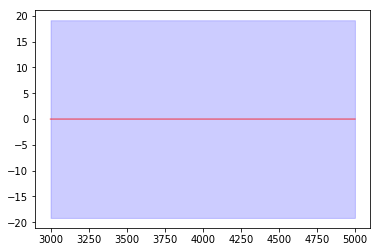

In [37]:
pred, pred_var = gp.predict(y, sl, return_var=True)
plt.fill_between(np.array(sl)[:,0], pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="b", alpha=0.2)
plt.plot(np.array(sl)[:,0], pred, "r", lw=1.5, alpha=0.5)

In [38]:
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

Initial ln-likelihood: -5171.70


In [39]:
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

t0=time()

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

print("done in %0.3fs" % (time() - t0))

      fun: 5159.446341963008
 hess_inv: array([[ 1.67807925e-03,  4.45869812e-04,  1.49362546e-04,
         3.15749590e-03,  2.06709637e-03,  3.33088727e-03,
         1.32571150e-03,  4.66711994e-04,  6.23391912e-03,
         4.07754096e-03,  5.04902097e-03,  5.67397205e-03,
         2.31761653e-03,  1.09879911e-03,  2.78609114e-03,
         7.17076232e-04],
       [ 4.45869812e-04,  4.16151651e-01, -8.65424675e-02,
        -4.45657252e-01, -1.58265493e-01, -3.81226491e-01,
         2.28593880e-02, -1.53762540e-02, -5.08207011e-01,
        -3.18980656e-01, -4.68600282e-01, -5.26340215e-01,
        -4.10370833e-01,  5.66253271e-02, -1.94870669e-01,
        -8.63698616e-02],
       [ 1.49362546e-04, -8.65424675e-02,  2.54999770e-01,
         5.43401380e-01,  2.16036317e-01,  2.64141629e-01,
        -7.74979140e-02, -2.29254307e-02,  6.77536862e-01,
         4.71716677e-01,  5.79317829e-01,  6.24263011e-01,
         3.39316299e-01, -7.22710032e-02,  3.32028597e-01,
        -4.33351263e-02

In [24]:
gp.log_likelihood(y)

-8579.398595841005

In [ ]:
kernel.get_parameter_vector # this was after running the minimize function

In [ ]:
kernel.get_parameter_vector

In [ ]:
pred, pred_var = gp.predict(y, sl, return_var=True)

plt.fill_between(np.array(sl)[:,0], pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="b", alpha=0.2)
plt.plot(np.array(sl)[:,0], pred, "r", lw=1.5, alpha=0.5)

In [ ]:
X, y = load_pcwpar(1)
yerr=[x*0.01 for x in y]

In [ ]:
kernel = kernels.ExpSquaredKernel(900**2,ndim=15,axes=0)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=1)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=2)*\
        kernels.ExpSquaredKernel(0.8**2,ndim=15,axes=3)*\
        kernels.ExpSquaredKernel(0.08**2,ndim=15,axes=4)*\
        kernels.ExpSquaredKernel(0.5**2,ndim=15,axes=5)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=6)*\
        kernels.ExpSquaredKernel(0.2**2,ndim=15,axes=7)*\
        kernels.ExpSquaredKernel(0.5**2,ndim=15,axes=8)*\
        kernels.ExpSquaredKernel(0.2**2,ndim=15,axes=9)*\
        kernels.ExpSquaredKernel(0.25**2,ndim=15,axes=10)*\
        kernels.ExpSquaredKernel(0.25**2,ndim=15,axes=11)*\
        kernels.ExpSquaredKernel(0.5**2,ndim=15,axes=12)*\
        kernels.ExpSquaredKernel(0.4**2,ndim=15,axes=13)*\
        kernels.ExpSquaredKernel(5**2,ndim=15,axes=14) * np.var(y)

gp = george.GP(kernel)
gp.compute(X,yerr)

In [ ]:
sl=[]
for i in range(11):
    x=[steps[0][5],steps[1][i]]
    for j in range(len(ranges)-2):
        x.append(steps[j+2][5])
    sl.append(x)

pred, pred_var = gp.predict(y, sl, return_var=True)
plt.fill_between(np.array(sl)[:,1], pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="b", alpha=0.2)
plt.plot(np.array(sl)[:,1], pred, "r", lw=1.5, alpha=0.5)

In [ ]:
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

In [ ]:
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

t0=time()

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

print("done in %0.3fs" % (time() - t0))

In [ ]:
sl=[]
for i in range(11):
    x=[steps[0][5],steps[1][i]]
    for j in range(len(ranges)-2):
        x.append(steps[j+2][5])
    sl.append(x)

pred, pred_var = gp.predict(y, sl, return_var=True)
plt.fill_between(np.array(sl)[:,1], pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="b", alpha=0.2)
plt.plot(np.array(sl)[:,1], pred, "r", lw=1.5, alpha=0.5)